In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import altair as alt
from glob import glob
from tqdm import tqdm_notebook


### Customization of prompts for sepsis-specific prioritization: 
We customized the prompt used in the automated prioritization workflow to focus on sepsis-specific criteria. The modified prompt assessed each gene's relevance to sepsis pathogenesis, host immune response, organ dysfunction, biomarker potential, and therapeutic implications. The customized prompt was designed as follows: 


For the Gene [input = official Gene Symbol]
1.	Provide the gene's official name
2.	Provide a brief summary of the gene's function.
3.	Give each of the following statements a score from 0 to 10, with 0 indicating no evidence and 10 indicating very strong evidence:

* *a.* The gene is associated with the pathogenesis of sepsis. Score: Based on evidence of the gene's involvement in the biological processes underlying sepsis, including but not limited to its role in the dysregulated host response to infection, organ dysfunction, or sepsis-related complications.
* *b.* The gene is associated with the host immune response in sepsis. Score: Based on evidence of the gene's involvement in the immune response during sepsis, including but not limited to its role in innate or adaptive immunity, inflammation, or immunosuppression.
* *c.* The gene is associated with sepsis-related organ dysfunction. Score: Based on evidence of the gene's involvement in the development or progression of organ dysfunction in sepsis, including but not limited to its role in cardiovascular, respiratory, renal, hepatic, or neurological dysfunction.
* *d.* The gene is relevant to circulating leukocytes immune biology in sepsis. Score: Based on evidence linking the gene to the development, function, or regulation of circulating leukocytes in the context of sepsis, including impacts on leukocyte differentiation, activation, signaling, or effector functions.  
* *e.* The gene or its products are currently being used as a biomarker for sepsis in clinical settings. Score: Based on evidence of the gene or its products' application as biomarkers for diagnosis, prognosis, or monitoring of sepsis in clinical settings, with a focus on their validated use and acceptance in medical practice.
* *f.* The gene has potential value as a blood transcriptional biomarker for sepsis. Score: Based on evidence supporting the gene's expression patterns in blood cells as reflective of sepsis or its severity, considering both current research findings and potential for future clinical utility.
* *g.* The gene is a known drug target for sepsis treatment. Score: Based on evidence of the gene or its encoded protein serving as a target for therapeutic intervention in sepsis, including approved drugs targeting this gene, compounds in clinical trials, or promising preclinical studies.
* *h.* The gene is therapeutically relevant for managing sepsis or its complications. Score: Based on evidence linking the gene to the management or treatment of sepsis or its associated complications, including its role as a potential target for adjunctive therapies or personalized treatment strategies.

*Scoring criteria:*
0 - No evidence found 1-3 - Very limited evidence 4-6 - Some evidence, but needs validation or is limited to certain conditions 7-8 - Good evidence 9-10 - Strong evidence

This prompt was integrated into the Python scripts that communicate with GPT-4 via the OpenAI and Microsoft Azure APIs, ensuring that the prioritization process was tailored to the specific requirements of sepsis monitoring.

### Run on HPC

python codes were run wiht default setting of API (temp =0.7; iteration =1). For each gene we capture the response of above question along with time taken. Code are avaiable in : (/Users/khant/JaX_work/g4API_app/bloodgen3Gensets/Sepsis/Sepsis)


In [2]:
!cat {"/Users/khant/JaX_work/g4API_app/bloodgen3Gensets/Sepsis/Sepsis/outResults_g4/resp_2-Sep.json"}

{
    "datasvc-openai-compsci-poc-gpt4-turbo_1": [
        "```json",
        "{",
        "  \"gene_name\": \"2-Sep\",",
        "  \"Brief_summary\": \"The gene '2-Sep' does not correspond to a standard gene nomenclature, and it is unclear which gene this refers to. Please provide the correct gene symbol or name for accurate information.\",",
        "  \"evidence_scores\": {",
        "    \"The gene is associated with the pathogenesis of sepsis. Score\": 0,",
        "    \"The gene is associated with the host immune response in sepsis. Score\": 0,",
        "    \"The gene is associated with sepsis-related organ dysfunction. Score\": 0,",
        "    \"The gene is relevant to circulating leukocytes immune biology in sepsis. Score\": 0,",
        "    \"The gene or its products are currently being used as a biomarker for sepsis in clinical settings. Score\": 0,",
        "    \"The gene has potential value as a blood transcriptional biomarker for sepsis. Score\": 0,",
        "   

In [4]:

# define key dictionary for each question for concrete formatting
import re
mainkey_qestion_key = {'summary':'Summary','Brief_summary':'Summary',
                       "gene_name":'geneSymbol',
               'pathogenesis':'a_pathogenic_assoc',
                'host immune response':'b_host_immune_Respo',
                'organ dysfunction':'c_organ_dysfunction',
                'circulating leukocytes immune biology':'d_circu_leu_imm_biol',
                'biomarker for sepsis in clinical settings':'e_biomarker_clinical',
                'blood transcriptional biomarker for sepsis':'f_pot_bolldtransc_biomarker',
                'known drug target for sepsis':'g_drug_target',
                'therapeutically relevant':'h_theraputically_rel',
               }


def find_keyword(sline, keyLib):
    for mk in keyLib.keys():

        # Regular expression pattern to find all combinations of the letters in 'gene'
        pattern = r'{}'.format(mk)

        # Finding all matches in the sample text
        matches = re.findall(pattern, sline, re.IGNORECASE)
        if matches:
            return keyLib[mk]
        else:
            next
    return False



def convert_stringtodict(lines, keylib):
    dict_line = {}
    for k in lines:
        ksplit = k.split(":")

        if len(ksplit) ==2:
            key_tmp = find_keyword(ksplit[0].strip("\'|\"|', |").strip(), keylib)
            val_tmp = ksplit[1].strip("\'|\"|',|{|} ").strip()
            if key_tmp and val_tmp:
                if (key_tmp == "Summary") | (key_tmp == "geneSymbol"):
                    dict_line[key_tmp] = val_tmp
                else:
                    try:
                        dict_line[key_tmp] = float(val_tmp)
                    except:
                        dict_line[key_tmp] = 0
            else:
                next
                # print ("error in ", ksplit)

    return dict_line

def truncate_json_at_time(filepath):
    with open(filepath, 'r') as file:
        content = file.read()

    # Find the index of the first occurrence of "time"
    time_index = content.find('"time"')
    if time_index != -1:
        # Find the index of the next "}" after "time"
        end_index = content.find('}', time_index)
        if end_index != -1:
            # Truncate the content after the "}"
            content = content[:end_index + 1]
            return content
    return "Time key not found or missing closing brace."

In [5]:
outdirPath = "/Users/khant/JaX_work/g4API_app/bloodgen3Gensets/Sepsis/outResults_g4/"


In [6]:
outdirPath = "/Users/khant/JaX_work/g4API_app/bloodgen3Gensets/Sepsis/outResults_g4/"
responseDF = []
error_JSON = []

for k in tqdm_notebook(glob(outdirPath+"resp_*.json")):
    gene_name = k.split("/")[-1].split("_")[-1].split(".")[0]
    try:
        response = json.load(open(k,'r'))
        response_keys = list(response.keys())
        tx = convert_stringtodict(response[response_keys[0]],mainkey_qestion_key)
        tx.update({'time':response['time'],'model':response_keys[0],'geneName':gene_name})
        responseDF.append(tx)
    except:
        try:
            truncated_json = json.loads(truncate_json_at_time(k))
            response_keys = list(truncated_json.keys())
            tx = convert_stringtodict(truncated_json[response_keys[0]],mainkey_qestion_key)
            tx.update({'time':response['time'],'model':response_keys[0],'geneName':gene_name})
            responseDF.append(tx)
        except:
            error_JSON.append([gene_name,k])
print ("success:",len(responseDF),"\nerror :",len(error_JSON))

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_10192/1687112963.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(glob(outdirPath+"resp_*.json")):


  0%|          | 0/11465 [00:00<?, ?it/s]

success: 11462 
error : 3


In [5]:
error_JSON = pd.DataFrame(error_JSON,columns=['gene_name','file_path']).set_index("gene_name")
error_JSON

,file_path
gene_name,
ANKRD30B,/Users/khant/JaX_work/g4API_app/bloodgen3Gense...
ALPP,/Users/khant/JaX_work/g4API_app/bloodgen3Gense...
ALS2CR14,/Users/khant/JaX_work/g4API_app/bloodgen3Gense...


In [6]:
!cat {error_JSON.file_path.values[2]}

{
    "datasvc-openai-compsci-poc-gpt4-turbo_1": [
        "```json",
        "{",
        "  \"gene_name\": \"ALS2CR14\",",
        "  \"Brief_summary\": \"ALS2CR14, or 'Amyotrophic lateral sclerosis 2 (juvenile) chromosome region, candidate 14', is a gene located on chromosome 2 in humans. As of the knowledge cutoff date, there is limited information regarding its function and clinical significance. The gene may need to be further researched to fully understand its role in human diseases and physiology.\",",
        "  \"evidence_scores\": {",
        "    \"The gene is associated with the pathogenesis of sepsis. Score\": 0,",
        "    \"The gene is associated with the host immune response in sepsis. Score\": 0,",
        "    \"The gene is associated with sepsis-related organ dysfunction. Score\": 0,",
        "    \"The gene is relevant to circulating leukocytes immune biology in sepsis. Score\": 0,",
        "    \"The gene or its products are currently being used as a biomark

In [7]:
sepsis_responseDF = pd.DataFrame(responseDF).set_index("geneName")
print (sepsis_responseDF.shape)

(11462, 12)


Text(5.069444444444452, 0.5, '# genes')

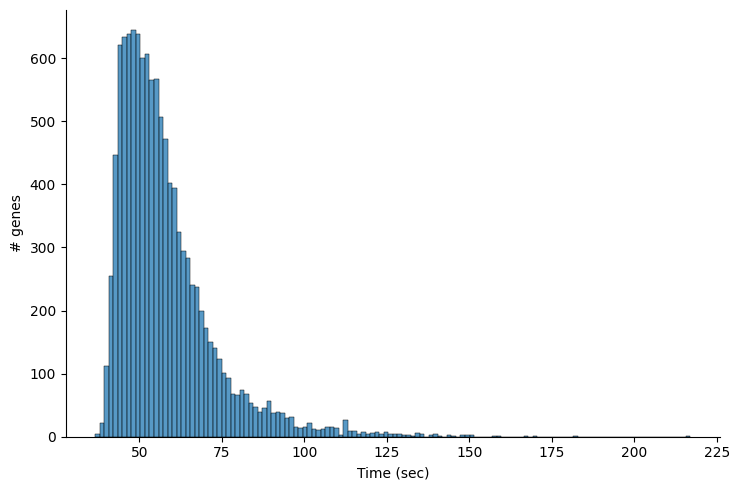

In [8]:

sns.displot(x="time",data=sepsis_responseDF,aspect=1.5)
plt.xlabel("Time (sec)")
plt.ylabel("# genes")

In [9]:
sepsis_responseDF.time.describe(), sepsis_responseDF.time.sum()/3600

(count    11462.000000
 mean        57.935023
 std         14.722009
 min         36.731793
 25%         47.928453
 50%         54.366516
 75%         63.368463
 max        216.940332
 Name: time, dtype: float64,
 184.45867555969292)

In [10]:
sepsis_responseDF.head()

,geneSymbol,Summary,a_pathogenic_assoc,b_host_immune_Respo,c_organ_dysfunction,d_circu_leu_imm_biol,e_biomarker_clinical,f_pot_bolldtransc_biomarker,g_drug_target,h_theraputically_rel,time,model
geneName,,,,,,,,,,,,
SYTL4,SYTL4,"SYTL4, also known as synaptotagmin-like 4, is ...",1.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,44.294304,datasvc-openai-compsci-poc-gpt4-turbo_1
OTUD6B,OTUD6B,"OTUD6B, also known as OTU domain-containing pr...",2.0,2.0,1.0,2.0,0.0,3.0,0.0,1.0,61.662107,datasvc-openai-compsci-poc-gpt4-turbo_1
LOC731823,LOC731823,The gene LOC731823 is a symbol used for a gene...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.485157,datasvc-openai-compsci-poc-gpt4-turbo_1
C5ORF3,C5ORF3,C5ORF3 (Chromosome 5 Open Reading Frame 3) is ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.420752,datasvc-openai-compsci-poc-gpt4-turbo_1
UFC1,UFC1,The UFC1 gene encodes a protein involved in ub...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.460391,datasvc-openai-compsci-poc-gpt4-turbo_1


In [11]:
geneBase = pd.read_csv("../../../../g4API_app/bloodgen3Gensets/Sepsis/data/ModuleTranscript_geneList.csv.gzip",compression="gzip").set_index("geneSymbol")
geneBase = geneBase.drop("Unnamed: 0",axis=1)
print (geneBase.shape)
geneBase.head()

(11465, 3)


,ModuleID,AggregateNumber,ModuleTitle
geneSymbol,,,
ALPP,M3.1,A29,Cell cycle
ALS2CR14,M3.1,A29,Cell cycle
ANKRD30B,M3.1,A29,Cell cycle
ARL16,M3.1,A29,Cell cycle
BCYRN1,M3.1,A29,Cell cycle


In [12]:
responseDF_geneInfo = sepsis_responseDF[['geneSymbol', 'Summary',]]
responseDF_geneInfo.head()

,geneSymbol,Summary
geneName,,
SYTL4,SYTL4,"SYTL4, also known as synaptotagmin-like 4, is ..."
OTUD6B,OTUD6B,"OTUD6B, also known as OTU domain-containing pr..."
LOC731823,LOC731823,The gene LOC731823 is a symbol used for a gene...
C5ORF3,C5ORF3,C5ORF3 (Chromosome 5 Open Reading Frame 3) is ...
UFC1,UFC1,The UFC1 gene encodes a protein involved in ub...


In [13]:
for ikey , ival in sepsis_responseDF[['geneSymbol']].iterrows():
    if not ikey == ival.geneSymbol:
        #print (ikey,ival.geneSymbol)
        responseDF_geneInfo.loc[ikey,'c_error'] = True

responseDF_geneInfo.groupby('c_error').size()

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_10192/2874223727.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  responseDF_geneInfo.loc[ikey,'c_error'] = True
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_10192/2874223727.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  responseDF_geneInfo.loc[ikey,'c_error'] = True


c_error
True    638
dtype: int64

In [14]:
responseDF_geneInfo[responseDF_geneInfo.c_error==True].reset_index().drop_duplicates("geneName")

,geneName,geneSymbol,Summary,c_error
0,HS,Example Gene Name,A brief summary describing the gene's function...,True
27,IDS,HypotheticalGene1,HypotheticalGene1 is implicated in various cel...,True
28,C17ORF81,C17orf81,"C17orf81, or chromosome 17 open reading frame ...",True
29,C1ORF116,C1orf116,"C1orf116, which stands for 'chromosome 1 open ...",True
30,LOC401845,NaN,LOC401845 is a gene that has not been characte...,True
...,...,...,...,...
594,C13ORF25,C13orf25,"C13orf25, also known as MIR17HG (miR-17-92 clu...",True
604,RP11-529I10,RP11-529I10.4,RP11-529I10.4 is a gene identified in the huma...,True
608,CA13,NaN,The Carbonic Anhydrase XIII (CA13) gene encode...,True
624,C1ORF142,C1orf142,"C1orf142, also known as Chromosome 1 Open Read...",True


In [15]:
sepsis_responseDF_actGene = sepsis_responseDF.loc[responseDF_geneInfo[responseDF_geneInfo.c_error.isna()].index]
print ("All genes: ", sepsis_responseDF.shape[0], "\nGenes where ene id matches:", sepsis_responseDF_actGene.shape[0])


All genes:  11462 
Genes where ene id matches: 10824


In [16]:
score_cols = [ 'a_pathogenic_assoc', 'b_host_immune_Respo',
       'c_organ_dysfunction', 'd_circu_leu_imm_biol', 'e_biomarker_clinical',
       'f_pot_bolldtransc_biomarker', 'g_drug_target', 'h_theraputically_rel',]

In [17]:
sepsis_responseDF_scores = sepsis_responseDF_actGene[score_cols]
print (sepsis_responseDF_scores.shape)


(10824, 8)


In [18]:
score_Iter = np.arange(1,10,1)
question_Iter = np.arange(1,7,1)

print (score_Iter, question_Iter)

responseGenes = []
for s in score_Iter:
    for q in question_Iter:
        res_num = sepsis_responseDF_scores[sepsis_responseDF_scores[sepsis_responseDF_scores>=s].fillna(0).astype(bool).sum(axis=1)>=q].shape[0]
        responseGenes.append([s,q,res_num])

responseGenesDF = pd.DataFrame(responseGenes,columns=['score','questions','genes_filtered'])

responseGenesDF

[1 2 3 4 5 6 7 8 9] [1 2 3 4 5 6]


,score,questions,genes_filtered
0,1,1,7156
1,1,2,7144
2,1,3,7143
3,1,4,7143
4,1,5,7141
5,1,6,7109
6,2,1,6682
7,2,2,5130
8,2,3,4764
9,2,4,4268


### Filter 1: select genes that have score at-least 5 in atleast more than one question

In [19]:
atL1_evd  = sepsis_responseDF_scores[sepsis_responseDF_scores[sepsis_responseDF_scores>=5].fillna(0).astype(bool).sum(axis=1)>=1]
print (sepsis_responseDF_scores.shape, atL1_evd.shape)

(10824, 8) (1070, 8)


In [20]:
atL1_evd.shape[0]/ sepsis_responseDF_scores.shape[0]

0.09885439763488545

In [21]:
atL1_evd['totalScore'] = atL1_evd.sum(axis=1)
atL1_evd.sort_values(by='totalScore')
atL1_evd_annpt = atL1_evd.join(geneBase.loc[atL1_evd.index])

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_10192/2590807127.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atL1_evd['totalScore'] = atL1_evd.sum(axis=1)


In [22]:
atL1_evd_annpt

,a_pathogenic_assoc,b_host_immune_Respo,c_organ_dysfunction,d_circu_leu_imm_biol,e_biomarker_clinical,f_pot_bolldtransc_biomarker,g_drug_target,h_theraputically_rel,totalScore,ModuleID,AggregateNumber,ModuleTitle
geneName,,,,,,,,,,,,
TOX,3.0,4.0,2.0,5.0,1.0,3.0,1.0,2.0,21.0,M16.18,A5,TBD
SRGN,4.0,5.0,3.0,6.0,2.0,4.0,1.0,3.0,28.0,M15.105,A35,Inflammation
OAS2,4.0,6.0,3.0,5.0,2.0,5.0,1.0,3.0,29.0,M8.3,A28,Type 1 Interferon
AVP,4.0,3.0,5.0,2.0,1.0,3.0,2.0,4.0,24.0,M16.16,A32,TBD
RFX5,3.0,5.0,2.0,5.0,1.0,4.0,1.0,3.0,24.0,M13.2,A1,Gene transcription
...,...,...,...,...,...,...,...,...,...,...,...,...
GATA1,3.0,4.0,2.0,5.0,1.0,3.0,1.0,2.0,21.0,M11.3,A37,Erythrocytes
GAB2,3.0,4.0,2.0,5.0,1.0,3.0,1.0,2.0,21.0,M14.19,A33,Inflammation
MAPK8IP1,4.0,5.0,3.0,5.0,2.0,4.0,2.0,3.0,28.0,M16.16,A32,TBD


### Overview

In [23]:
print ("Unique Modules:",atL1_evd_annpt.ModuleID.nunique(),\
       "\nUnique Aggregate: ", atL1_evd_annpt.AggregateNumber.nunique(),\
        "\nUnique ModuleTitle : ", atL1_evd_annpt.ModuleTitle.nunique())

Unique Modules: 297 
Unique Aggregate:  35 
Unique ModuleTitle :  32


In [24]:
scoreOrder = atL1_evd_annpt.groupby('ModuleTitle')['totalScore'].agg("median").sort_values().index
titlBoxplot = alt.Chart(atL1_evd_annpt,height=200).mark_boxplot().encode(
    x=alt.X('ModuleTitle',sort=list(scoreOrder),axis=alt.Axis(title="Module Function Title",titleFontSize=10,labelFontSize=14)),
    y='totalScore'
)

module_bar = alt.Chart(atL1_evd_annpt,height=150).mark_bar().encode(
    x=alt.X('ModuleTitle',sort=list(scoreOrder),axis=alt.Axis(labels=False,title='')),
    y=alt.Y('distinct(ModuleID)',axis=alt.Axis(title="Module Count"))
)
module_text = module_bar.mark_text(
    align="center",
    baseline="middle",
    dy=-5,
    size=14
).encode(text="distinct(ModuleID)")
module_bar_plot = module_bar+module_text

gene_bar = alt.Chart(atL1_evd_annpt,height=150).mark_bar().encode(
    x=alt.X('ModuleTitle',sort=list(scoreOrder),axis=alt.Axis(labels=False,title='')),
    y=alt.Y('count(ModuleID)',axis=alt.Axis(title="Gene Count"))
)
gene_text = gene_bar.mark_text(
    align="center",
    baseline="middle",
    dy=-5,
    size=14
).encode(text="count(ModuleID)")
gene_bar_plot  = gene_bar+gene_text

alt.vconcat(gene_bar_plot,module_bar_plot, titlBoxplot).resolve_scale(
    x='shared'
)

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.VConcatChart(...)

### Hierarchical clustering for clustering genews based on their response

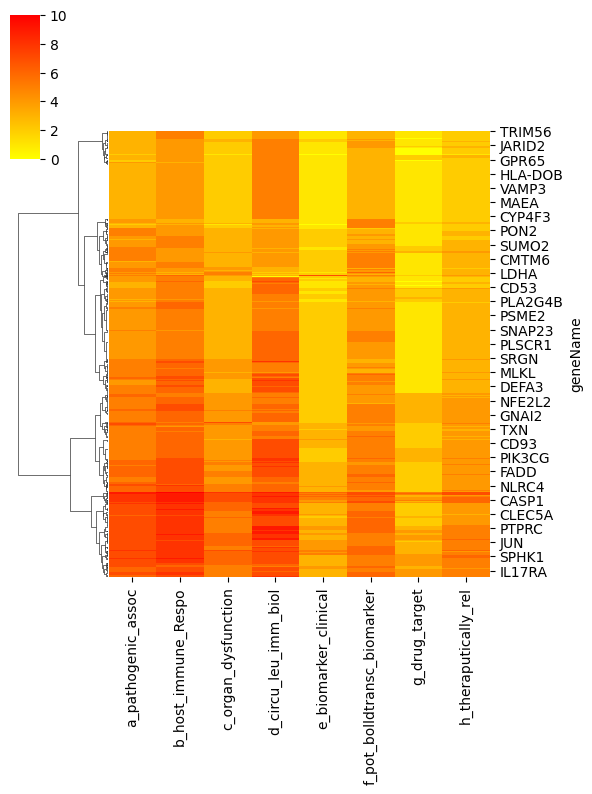

In [25]:
dataX = atL1_evd_annpt[score_cols].fillna(0)
absHM = sns.clustermap(dataX,col_cluster=False,method="ward",figsize=(6,8),cmap="autumn_r")

In [26]:
from scipy import stats as sT

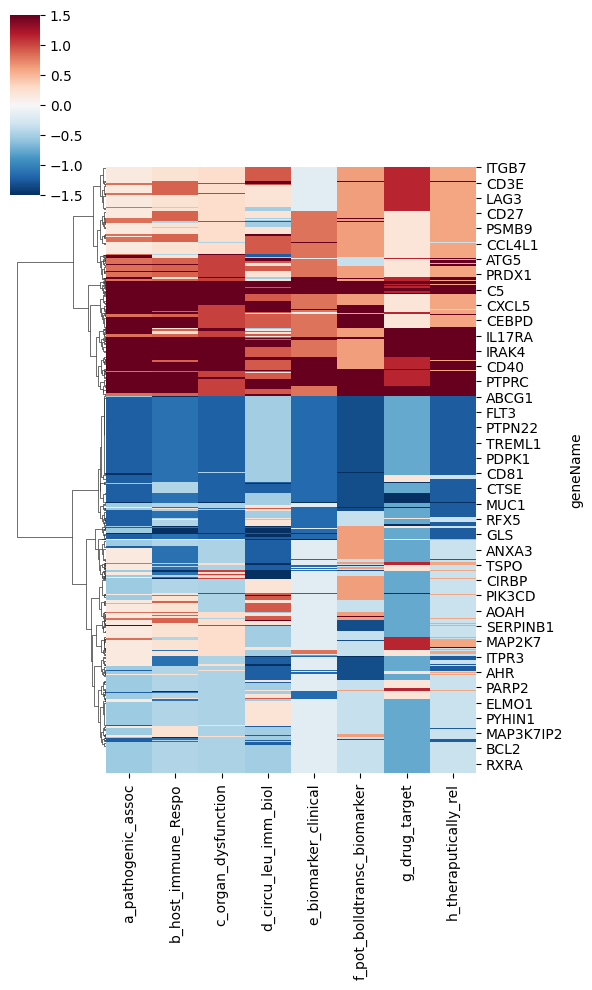

In [27]:
g = sns.clustermap(dataX.apply(sT.zscore,axis=0),cmap="RdBu_r",figsize=(6,10),
                   vmin=-1.5,vmax=1.5,method="ward",col_cluster=False)

In [28]:
import matplotlib.colors as mcolors
from scipy.cluster.hierarchy import fcluster

figDir = "~"

def get_labelClusterMap(cData,row_linkage, spot_id_colors,heatmap_color="RdBu_r",data_scale="normalized"):
    if data_scale=="normalized":
        g = sns.clustermap(cData.fillna(0),
                    method="ward",row_cluster=True,row_linkage=row_linkage, col_cluster=False,
                    figsize=(4,8),cmap=heatmap_color,vmin=-1.5,vmax=1.5,dendrogram_ratio=0.15,
                    row_colors=spot_id_colors.c_color,
                    cbar_pos=(0.75,0.7,0.03,0.15),
                    cbar_kws={"label":'score (z-transformed)'})
    elif data_scale=="absolute":
         g = sns.clustermap(cData.fillna(0),
                    method="ward",row_cluster=True,row_linkage=row_linkage, col_cluster=False,
                    figsize=(4,8),cmap=heatmap_color,vmin=1,vmax=9,dendrogram_ratio=0.15,
                    row_colors=spot_id_colors.c_color,
                    cbar_pos=(0.75,0.7,0.03,0.15),
                    cbar_kws={"label":'score (absolute)'})
         
    g.ax_heatmap.set_yticks([])
    plt.tight_layout()
    plt.savefig("../../../../g4API_app/bloodgen3Gensets/Sepsis/Figures/hirarchicalCluster.pdf",format="pdf")

def num_distinct_color(ncols, schema="tab10"):
    # get schema from : https://matplotlib.org/stable/users/explain/colors/colormaps.html
    # Get the 'tab10' colormap which contains 10 distinct colors
    cmap = plt.get_cmap(schema)
    # Select 6 distinct colors from the colormap
    colors = reversed([cmap(i/10) for i in range(ncols)])

    # Convert colors to hex format correctly
    return {str(cnum):mcolors.rgb2hex(color) for cnum,color in zip(np.arange(1,ncols+1),colors)}

def get_clusterMembers(gDataObj, row_linkage, numCluster=5, schema="tab10",data_scale="normalized", heatmap_color="RdBu_r"):
    # row_linkage = gDataObj.dendrogram_row.linkage
    clusters = fcluster(row_linkage, numCluster, criterion="maxclust")
    clustCols = num_distinct_color(numCluster, schema=schema)

    spot_id_cluste = []
    for spotid, clister in zip(gDataObj.data.index, clusters):
        spot_id_cluste.append([spotid,str(clister)])

    spot_id_cluste = pd.DataFrame(spot_id_cluste,columns=['spotID','c_num'])
    spot_id_cluste['c_color'] = spot_id_cluste.c_num.map(clustCols)
    spot_id_cluste = spot_id_cluste.set_index("spotID")
    get_labelClusterMap(gDataObj.data, row_linkage, spot_id_cluste, data_scale=data_scale, heatmap_color=heatmap_color)
    return spot_id_cluste

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_10192/3423203827.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


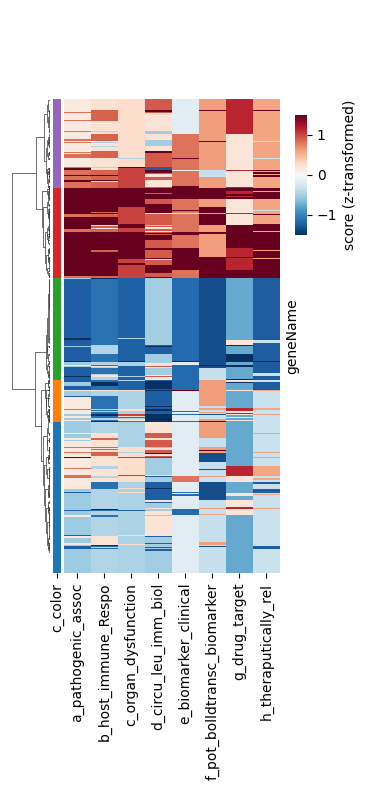

In [29]:
clustNum = get_clusterMembers(g,g.dendrogram_row.linkage, numCluster=5,schema="tab20",data_scale="normalized",heatmap_color="RdBu_r")

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_10192/3423203827.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


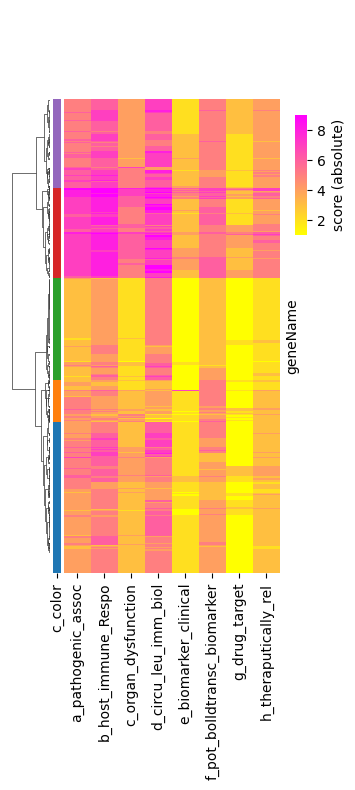

In [30]:
clustCol = get_clusterMembers(absHM,g.dendrogram_row.linkage, numCluster=5,schema="tab20",data_scale="absolute",heatmap_color="spring_r")

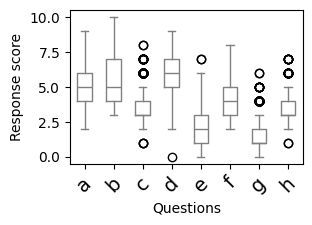

In [31]:

gbaox = dataX.plot(kind="box",figsize=(3,2),color="gray")
gbaox.set_xticklabels(['a','b','c','d','e','f','g','h'], rotation=45,fontdict={'size':14})
plt.xlabel("Questions")
plt.ylabel("Response score")
plt.show()

In [32]:
atL1_evd_annpt_cluster = atL1_evd_annpt.join(clustNum)

## sort cluster numbers as per popularity 
question_clusterAgg = atL1_evd_annpt_cluster.groupby('c_num')[score_cols].agg(['median','std']).\
    unstack().reset_index().pivot(index=['level_0','c_num'],columns='level_1',values=0)

question_clusterAgg = question_clusterAgg.reset_index().rename({'level_0':'questions'},axis=1)


def popularIndex(kgrp):
    return kgrp[kgrp>=5].shape[0]/kgrp.shape[0]

popularCluster = question_clusterAgg.groupby('c_num')['median'].apply(popularIndex)
popularcluserName = popularCluster.idxmax()

popularCluster = popularCluster.to_frame().sort_values(by="median",ascending=False).reset_index()
popularCluster['c_index'] = [i+1 for i in popularCluster.index]
rename_Cluster = popularCluster.set_index("c_num")['c_index'].to_dict()

print ("Populat cluster in this experiment:", popularcluserName, "\nrenaming clustes as: ", rename_Cluster)



Populat cluster in this experiment: 2 
renaming clustes as:  {'2': 1, '1': 2, '4': 3, '5': 4, '3': 5}


In [33]:
question_clusterAgg['ClusterName'] = question_clusterAgg['c_num'].map(rename_Cluster)
question_clusterAgg.head()

level_1,questions,c_num,median,std,ClusterName
0,a_pathogenic_assoc,1,5.0,0.596674,2
1,a_pathogenic_assoc,2,7.0,0.523179,1
2,a_pathogenic_assoc,3,3.0,0.328782,5
3,a_pathogenic_assoc,4,5.0,0.782364,3
4,a_pathogenic_assoc,5,4.0,0.642084,4


#### Overall response score for each question " cluster wise"

In [34]:
alt.Chart(question_clusterAgg).mark_point(filled=True).encode(
    y=alt.Y('questions',axis=alt.Axis(labelFontSize=14)),
    x=alt.X('ClusterName:O'),
    color=alt.Color("median",scale=alt.Scale(scheme="redblue",reverse=True,domainMin=0.5,domainMax=8,domainMid=4,clamp=True)),
    size=alt.Size('std',scale=alt.Scale(reverse=True)),
    tooltip=["median","std"]
)

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [35]:
atL1_evd_annpt_cluster['ClusterName'] = atL1_evd_annpt_cluster['c_num'].map(rename_Cluster)
atL1_evd_annpt_cluster.head()

,a_pathogenic_assoc,b_host_immune_Respo,c_organ_dysfunction,d_circu_leu_imm_biol,e_biomarker_clinical,f_pot_bolldtransc_biomarker,g_drug_target,h_theraputically_rel,totalScore,ModuleID,AggregateNumber,ModuleTitle,c_num,c_color,ClusterName
geneName,,,,,,,,,,,,,,,
TOX,3.0,4.0,2.0,5.0,1.0,3.0,1.0,2.0,21.0,M16.18,A5,TBD,3,#2ca02c,5
SRGN,4.0,5.0,3.0,6.0,2.0,4.0,1.0,3.0,28.0,M15.105,A35,Inflammation,5,#1f77b4,4
OAS2,4.0,6.0,3.0,5.0,2.0,5.0,1.0,3.0,29.0,M8.3,A28,Type 1 Interferon,5,#1f77b4,4
AVP,4.0,3.0,5.0,2.0,1.0,3.0,2.0,4.0,24.0,M16.16,A32,TBD,4,#ff7f0e,3
RFX5,3.0,5.0,2.0,5.0,1.0,4.0,1.0,3.0,24.0,M13.2,A1,Gene transcription,3,#2ca02c,5


In [37]:
atL1_evd_annpt_cluster = atL1_evd_annpt_cluster.loc[g.data2d.index]

In [38]:
atL1_evd_annpt_cluster.to_csv("../../../../g4API_app/bloodgen3Gensets/Sepsis/OutTable/GenelevelData_annnotated.csv")

In [37]:
geneResponseCaptured = responseDF_geneInfo.loc[atL1_evd_annpt_cluster.index].join(atL1_evd_annpt_cluster[['totalScore','ModuleID','AggregateNumber','ModuleTitle','ClusterName']])
geneResponseCaptured = geneResponseCaptured.sort_values(by=['ClusterName','totalScore'],ascending=[True, False])
geneResponseCaptured

,geneSymbol,Summary,c_error,totalScore,ModuleID,AggregateNumber,ModuleTitle,ClusterName
geneName,,,,,,,,
IL1B,IL1B,IL1B (Interleukin 1 Beta) is a proinflammatory...,NaN,62.0,M15.37,A35,Inflammation,1
TNF,TNF,"The TNF gene encodes tumor necrosis factor, a ...",NaN,61.0,M15.7,A26,Monocytes,1
HMGB1,HMGB1,High Mobility Group Box 1 (HMGB1) is a non-his...,NaN,58.0,M14.44,A2,Protein synthesis,1
TLR4,TLR4,"TLR4, or Toll-like receptor 4, is a protein th...",NaN,57.0,M15.26,A35,Neutrophils,1
IL8,IL8,"Interleukin 8 (IL8), also known as CXCL8, is a...",NaN,57.0,M16.49,A25,Inflammation,1
...,...,...,...,...,...,...,...,...
ZNF683,ZNF683,"ZNF683, also known as HOBIT, is a gene encodin...",NaN,20.0,M9.1,A2,Cytotoxic lymphocytes,5
BTG2,BTG2,"BTG2, also known as B-cell translocation gene ...",NaN,20.0,M15.25,A4,TBD,5
EDG6,EDG6,"EDG6, also known as sphingosine-1-phosphate re...",NaN,19.0,M13.1,A35,Inflammation,5


In [373]:
geneResponseCaptured.to_csv("../../../../g4API_app/bloodgen3Gensets/Sepsis/OutTable/capturedGeneJustification.csv")

In [38]:
color_key = atL1_evd_annpt_cluster[['ClusterName','c_color']].sort_values(by="ClusterName").set_index("ClusterName").to_dict()['c_color']
print (color_key.keys(), color_key.values())

dict_keys([1, 2, 3, 4, 5]) dict_values(['#d62728', '#9467bd', '#ff7f0e', '#1f77b4', '#2ca02c'])


In [39]:
funct_bar = alt.Chart(atL1_evd_annpt_cluster.reset_index(),height=150,width=200).mark_bar().encode(
    x=alt.X('ClusterName:N',sort=sorted(list(color_key.keys())), axis=alt.Axis(title="Cluster",labelFontSize=14)),
    y=alt.Y('count(geneName)',axis=alt.Axis(title="Gene Count")),
    color=alt.Color('ClusterName:O',scale=alt.Scale(domain=list(color_key.keys()),range=list(color_key.values())))
)
func_text = funct_bar.mark_text(
    align="center",
    baseline="middle",
    dy=-5,
    size=14
).encode(text="count(geneName)")
_bar_plot  = funct_bar+func_text

_bar_plot

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

### Module-Title reponse profile

In [40]:

title_agg = pd.crosstab(atL1_evd_annpt_cluster.ClusterName,atL1_evd_annpt_cluster.ModuleTitle ,normalize=1)
title_aggX = title_agg.unstack().reset_index().rename({0:'fractionPresence'},axis=1)
title_aggX.head()

,ModuleTitle,ClusterName,fractionPresence
0,Antigen presentation,1,0.166667
1,Antigen presentation,2,0.000000
2,Antigen presentation,3,0.000000
3,Antigen presentation,4,0.333333
4,Antigen presentation,5,0.500000


In [41]:
sorted_names = list(title_aggX.sort_values(by=['ClusterName','fractionPresence'],ascending=[True,False]).ModuleTitle.values)

alt.Chart(title_aggX,height=200).mark_bar(filled=True,).encode(
    x=alt.X("ModuleTitle",sort=sorted_names,axis=alt.Axis(labelFontSize=14)),
    y=alt.Y("fractionPresence"),
    color=alt.Color('ClusterName:O',scale=alt.Scale(domain=list(color_key.keys()),range=list(color_key.values())))
)

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

### Mofdule response profile

In [42]:
moduleID_agg = []
for kname, kgrp in atL1_evd_annpt_cluster.groupby('ModuleID'):
    totalcount = kgrp.shape[0]
    total_geneinModule_base = geneBase[geneBase.ModuleID==kname].shape[0]
    tmp = {}
    for cname, cgrp in kgrp.groupby("ClusterName"):
        tmp={}
        tmp['ModuleID'] = kname
        tmp['c_id'] = cname
        tmp['ModuleTitle']=cgrp.ModuleTitle.unique()[0]
        tmp['AggregateNumber'] = cgrp.AggregateNumber.unique()[0]
        tmp['geneCount'] = cgrp.shape[0]
        tmp['geneFraction'] = cgrp.shape[0]/totalcount
        tmp['geneList'] = ",".join(list(cgrp.index))
        tmp['pct_geneModule'] = (cgrp.shape[0]/total_geneinModule_base)*100
        for k in score_cols:
            tmp[k] = cgrp[k].mean()

        moduleID_agg.append(tmp)

module_agg_DF = pd.DataFrame(moduleID_agg)
module_agg_DF

,ModuleID,c_id,ModuleTitle,AggregateNumber,geneCount,geneFraction,geneList,pct_geneModule,a_pathogenic_assoc,b_host_immune_Respo,c_organ_dysfunction,d_circu_leu_imm_biol,e_biomarker_clinical,f_pot_bolldtransc_biomarker,g_drug_target,h_theraputically_rel
0,M10.1,1,Interferon,A28,3,0.250000,"IRF7,DDX58,STAT1",15.000000,7.000000,8.333333,5.333333,7.333333,3.000000,5.666667,2.666667,4.333333
1,M10.1,2,Interferon,A28,3,0.250000,"ZBP1,GBP1,GBP5",15.000000,5.666667,7.000000,4.333333,6.666667,2.333333,5.000000,2.666667,4.000000
2,M10.1,4,Interferon,A28,4,0.333333,"IFIT5,IFIT2,PARP14,IFIH1",20.000000,4.500000,5.750000,3.250000,6.000000,2.000000,4.500000,1.000000,3.000000
3,M10.1,5,Interferon,A28,2,0.166667,"TRIM22,LAP3",10.000000,3.000000,4.000000,2.000000,5.000000,1.000000,4.000000,1.000000,2.000000
4,M10.2,2,Protein synthesis,A9,1,0.250000,F2R,5.263158,6.000000,7.000000,5.000000,7.000000,3.000000,4.000000,2.000000,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,M9.1,2,Cytotoxic lymphocytes,A2,1,0.052632,IL2RB,3.571429,6.000000,7.000000,4.000000,7.000000,3.000000,5.000000,2.000000,4.000000
630,M9.1,4,Cytotoxic lymphocytes,A2,8,0.421053,"KLRC1,GNLY,CCL4L2,KLRD1,GZMA,NKG7,CD160,KIR2DL3",28.571429,4.250000,5.250000,3.250000,6.250000,2.000000,4.375000,1.125000,3.000000
631,M9.1,5,Cytotoxic lymphocytes,A2,9,0.473684,"KIR3DL1,EDG8,EOMES,KLRF1,PRF1,KIR2DL4,GZMH,KLR...",32.142857,3.111111,4.444444,2.111111,5.111111,1.111111,3.111111,0.888889,2.111111
632,M9.2,4,Erythrocytes,A37,1,0.333333,BCL2L1,3.333333,5.000000,5.000000,4.000000,5.000000,2.000000,4.000000,1.000000,3.000000


In [43]:
module_agg_DF.ModuleID.nunique()

297

In [44]:
module_agg_DF = module_agg_DF.sort_values(by=['c_id','geneFraction'],ascending=[True,False]).reset_index().drop('index',axis=1)
module_agg_DF


,ModuleID,c_id,ModuleTitle,AggregateNumber,geneCount,geneFraction,geneList,pct_geneModule,a_pathogenic_assoc,b_host_immune_Respo,c_organ_dysfunction,d_circu_leu_imm_biol,e_biomarker_clinical,f_pot_bolldtransc_biomarker,g_drug_target,h_theraputically_rel
0,M12.15,1,Cell cycle,A27,1,1.000000,CD38,5.882353,7.0,8.0,6.0,8.0,4.0,5.0,3.0,5.0
1,M12.9,1,Protein phosphorylation,A38,1,1.000000,CTSB,2.500000,7.0,7.0,6.0,7.0,4.0,5.0,3.0,5.0
2,M13.31,1,TBD,A25,2,1.000000,"CXCR4,CD68",11.764706,7.0,8.0,6.0,8.0,4.0,5.5,3.5,4.5
3,M14.20,1,Gene transcription,A1,1,1.000000,SIGIRR,4.545455,7.0,8.0,6.0,7.0,3.0,5.0,2.0,4.0
4,M14.33,1,Proteolysis,A30,1,1.000000,PTPRC,5.555556,7.0,8.0,5.0,9.0,4.0,6.0,3.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,M13.22,5,Neutrophils,A35,2,0.100000,"VNN2,ADAM8",3.333333,3.0,4.0,2.0,5.0,1.0,3.0,1.5,2.0
630,M16.3,5,T cells,A6,1,0.100000,SWAP70,0.934579,3.0,4.0,2.0,5.0,1.0,3.0,1.0,2.0
631,M16.1,5,TBD,A33,1,0.076923,MS4A3,0.854701,2.0,4.0,1.0,5.0,0.0,3.0,0.0,1.0
632,M8.3,5,Type 1 Interferon,A28,1,0.076923,HERC5,5.882353,3.0,5.0,2.0,4.0,1.0,3.0,1.0,2.0


In [45]:
module_agg_DF.to_csv("../../../../g4API_app/bloodgen3Gensets/Sepsis/OutTable/ModulePriorityTable.csv")

In [46]:
module_agg_DF

,ModuleID,c_id,ModuleTitle,AggregateNumber,geneCount,geneFraction,geneList,pct_geneModule,a_pathogenic_assoc,b_host_immune_Respo,c_organ_dysfunction,d_circu_leu_imm_biol,e_biomarker_clinical,f_pot_bolldtransc_biomarker,g_drug_target,h_theraputically_rel
0,M12.15,1,Cell cycle,A27,1,1.000000,CD38,5.882353,7.0,8.0,6.0,8.0,4.0,5.0,3.0,5.0
1,M12.9,1,Protein phosphorylation,A38,1,1.000000,CTSB,2.500000,7.0,7.0,6.0,7.0,4.0,5.0,3.0,5.0
2,M13.31,1,TBD,A25,2,1.000000,"CXCR4,CD68",11.764706,7.0,8.0,6.0,8.0,4.0,5.5,3.5,4.5
3,M14.20,1,Gene transcription,A1,1,1.000000,SIGIRR,4.545455,7.0,8.0,6.0,7.0,3.0,5.0,2.0,4.0
4,M14.33,1,Proteolysis,A30,1,1.000000,PTPRC,5.555556,7.0,8.0,5.0,9.0,4.0,6.0,3.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,M13.22,5,Neutrophils,A35,2,0.100000,"VNN2,ADAM8",3.333333,3.0,4.0,2.0,5.0,1.0,3.0,1.5,2.0
630,M16.3,5,T cells,A6,1,0.100000,SWAP70,0.934579,3.0,4.0,2.0,5.0,1.0,3.0,1.0,2.0
631,M16.1,5,TBD,A33,1,0.076923,MS4A3,0.854701,2.0,4.0,1.0,5.0,0.0,3.0,0.0,1.0
632,M8.3,5,Type 1 Interferon,A28,1,0.076923,HERC5,5.882353,3.0,5.0,2.0,4.0,1.0,3.0,1.0,2.0


In [47]:
stackedBar = alt.Chart(module_agg_DF,height=300,width=900).mark_bar(filled=True,).encode(
    x=alt.X("ModuleID",sort=list(module_agg_DF.ModuleID.values),axis=alt.Axis(title="ModuleID",labels=False)),
    y=alt.Y("geneFraction"),
    color=alt.Color('c_id:O',scale=alt.Scale(domain=list(color_key.keys()),range=list(color_key.values()))),
    tooltip=list(module_agg_DF.columns)
)
tCount = alt.Chart(module_agg_DF,height=100,width=900).mark_bar(filled=True,color="gray").encode(
    x=alt.X("ModuleID",sort=list(module_agg_DF.ModuleID.unique()),axis=alt.Axis(title="ModuleID",labels=False)),
    y=alt.Y("sum(geneCount)"),
    tooltip=["ModuleID","sum(geneCount)"]
)

tCount_pct = alt.Chart(module_agg_DF,height=100,width=900).mark_bar(filled=True,color="gray").encode(
    x=alt.X("ModuleID",sort=list(module_agg_DF.ModuleID.unique()),axis=alt.Axis(title="ModuleID",labels=False)),
    y=alt.Y("sum(pct_geneModule)"),
    tooltip=["ModuleID","sum(pct_geneModule)"]
)

moduleFracPlot = alt.vconcat(tCount_pct, tCount, stackedBar)
moduleFracPlot

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df

alt.VConcatChart(...)

In [54]:
testModule = "M10.4"
total_gene = geneBase[geneBase.ModuleID==testModule].shape[0]
foundGene = module_agg_DF[module_agg_DF.ModuleID==testModule].geneCount.sum()
fraction = (foundGene/total_gene)*100
print (testModule, "\ntotal gene in module", total_gene, "\nFound genes = ", foundGene, "\npct =",fraction  )

M10.4 
total gene in module 13 
Found genes =  11 
pct = 84.61538461538461


### Filtering modules based on gene population

In [222]:
moduleGeneSum =  module_agg_DF.groupby("ModuleID")['geneCount'].sum()
moduleGeneSum[moduleGeneSum>2]

ModuleID
M10.1    12
M10.2     4
M10.3     3
M10.4    11
M12.1     3
         ..
M8.1      6
M8.2      8
M8.3     13
M9.1     19
M9.2      3
Name: geneCount, Length: 138, dtype: int64

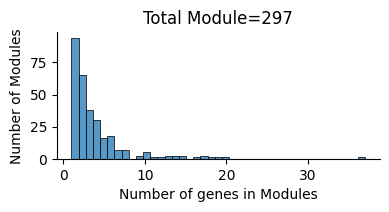

In [304]:
sns.displot(moduleGeneSum,aspect=2,height=2)
plt.xlabel("Number of genes in Modules")
plt.ylabel("Number of Modules")
plt.title("Total Module={}".format(moduleGeneSum.shape[0]))
plt.show()

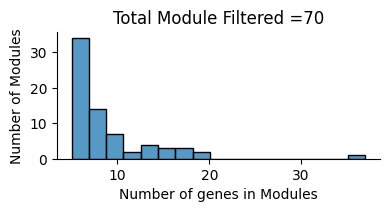

In [305]:
moduleGeneSum_filtered = moduleGeneSum[moduleGeneSum>=5]
sns.displot(moduleGeneSum_filtered,aspect=2,height=2)
plt.xlabel("Number of genes in Modules")
plt.ylabel("Number of Modules")
plt.title("Total Module Filtered ={}".format(moduleGeneSum_filtered.shape[0]))
plt.show()

In [306]:
filter_Dx = module_agg_DF[module_agg_DF.ModuleID.isin(moduleGeneSum_filtered.index)]

stackedBar = alt.Chart(filter_Dx,height=300,width=900).mark_bar(filled=True,).encode(
    x=alt.X("ModuleID",sort=list(filter_Dx.ModuleID.values),axis=alt.Axis(title="ModuleID",labels=False)),
    y=alt.Y("geneFraction"),
    color=alt.Color('c_id:O',scale=alt.Scale(domain=list(color_key.keys()),range=list(color_key.values()))),
    tooltip=list(filter_Dx.columns)
)

tCount = alt.Chart(filter_Dx,height=100,width=900).mark_bar(filled=True,color="gray").encode(
    x=alt.X("ModuleID",sort=list(filter_Dx.ModuleID.unique()),axis=alt.Axis(title="",labels=True)),
    y=alt.Y("sum(geneCount)"),
    tooltip=["ModuleID","sum(geneCount)"]
)


moduleFracPlot = alt.vconcat(tCount, stackedBar)
moduleFracPlot

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.VConcatChart(...)

In [167]:
atL1_evd_annpt_cluster.columns

Index(['a_pathogenic_assoc', 'b_host_immune_Respo', 'c_organ_dysfunction',
       'd_circu_leu_imm_biol', 'e_biomarker_clinical',
       'f_pot_bolldtransc_biomarker', 'g_drug_target', 'h_theraputically_rel',
       'totalScore', 'ModuleID', 'AggregateNumber', 'ModuleTitle', 'c_num',
       'c_color'],
      dtype='object')


The Sepsis task is almost complete [11046/11465 bloodgen3 transcript] . I have overloaded GPT4-turbo with some parallel processing and completed the over the weekend. Hopefully, I will be able to run though all by tonight. 

As we run thought, I put in some analysis on this data (expecting not much change with new 300 genes). Please see the attached slides. Here are some key observations,
1.	Approx 10% of gene were found to have minimum association with Sepsis (filter1).
2.	Highest fraction of gene is from “TBD” function title.
3.	Top scoring genes were from “Neutrophil activation”, “Cell adhesion”, “Protelysis”.
4.	Approx 20% of gene were found to have highest scoring in all question, from hierarchical clustering.
5.	From H-clustering of genes , cluster 5 has most promising candidate gens.
6.	Plotted aggregate rep response for “module title” and “module IDs”. See attached html file

PS: as expected we incurred around 200 USD for this task.


### Module Aggregate grouping

In [55]:
atL1_evd_annpt_cluster.head()

,a_pathogenic_assoc,b_host_immune_Respo,c_organ_dysfunction,d_circu_leu_imm_biol,e_biomarker_clinical,f_pot_bolldtransc_biomarker,g_drug_target,h_theraputically_rel,totalScore,ModuleID,AggregateNumber,ModuleTitle,c_num,c_color,ClusterName
geneName,,,,,,,,,,,,,,,
TOX,3.0,4.0,2.0,5.0,1.0,3.0,1.0,2.0,21.0,M16.18,A5,TBD,3,#2ca02c,5
SRGN,4.0,5.0,3.0,6.0,2.0,4.0,1.0,3.0,28.0,M15.105,A35,Inflammation,5,#1f77b4,4
OAS2,4.0,6.0,3.0,5.0,2.0,5.0,1.0,3.0,29.0,M8.3,A28,Type 1 Interferon,5,#1f77b4,4
AVP,4.0,3.0,5.0,2.0,1.0,3.0,2.0,4.0,24.0,M16.16,A32,TBD,4,#ff7f0e,3
RFX5,3.0,5.0,2.0,5.0,1.0,4.0,1.0,3.0,24.0,M13.2,A1,Gene transcription,3,#2ca02c,5


In [56]:
geneBase.head()

,ModuleID,AggregateNumber,ModuleTitle
geneSymbol,,,
ALPP,M3.1,A29,Cell cycle
ALS2CR14,M3.1,A29,Cell cycle
ANKRD30B,M3.1,A29,Cell cycle
ARL16,M3.1,A29,Cell cycle
BCYRN1,M3.1,A29,Cell cycle


In [58]:
modaggregate_grp = []
for kname, kgrp in atL1_evd_annpt_cluster.groupby('AggregateNumber'):
    totalcount = kgrp.shape[0]
    totalGene_aggregate = geneBase[geneBase.AggregateNumber==kname].shape[0]
    tmp = {}
    for cname, cgrp in kgrp.groupby("ClusterName"):
        tmp={}
        tmp['ModuleAggregate'] = kname
        tmp['ModuleTitle'] = ",".join(cgrp.ModuleTitle.unique())
        tmp['ModuleIds'] = ",".join(cgrp.ModuleID.unique())
        tmp['c_id'] = cname
        tmp['geneCount'] = cgrp.shape[0]
        tmp['geneFraction'] = cgrp.shape[0]/totalcount
        tmp['geneList'] = ",".join(list(cgrp.index))
        tmp['pct_geneAggregate'] = (cgrp.shape[0]/totalGene_aggregate)*100
        for k in score_cols:
            tmp[k] = cgrp[k].mean()

        modaggregate_grp.append(tmp)

modaggregate_grp_DF = pd.DataFrame(modaggregate_grp)
modaggregate_grp_DF = modaggregate_grp_DF.sort_values(by=['c_id','geneFraction'],ascending=[True,False]).reset_index().drop('index',axis=1)
modaggregate_grp_DF

,ModuleAggregate,ModuleTitle,ModuleIds,c_id,geneCount,geneFraction,geneList,pct_geneAggregate,a_pathogenic_assoc,b_host_immune_Respo,c_organ_dysfunction,d_circu_leu_imm_biol,e_biomarker_clinical,f_pot_bolldtransc_biomarker,g_drug_target,h_theraputically_rel
0,A11,TBD,M15.67,1,2,0.666667,"B2M,S100A8",11.111111,7.500000,8.500000,6.000000,8.000000,6.000000,6.500000,3.000000,4.500000
1,A27,Cell cycle,"M12.15,M16.60",1,2,0.400000,"CD38,CCR5",1.941748,7.000000,8.000000,6.000000,8.000000,3.500000,5.000000,3.500000,5.000000
2,A38,"Protein phosphorylation,Neutrophil activation","M12.9,M10.4",1,7,0.333333,"CTSB,MPO,LTF,OLFM4,BPI,CTSG,DEFA1",8.641975,7.000000,7.857143,5.142857,8.142857,3.571429,5.857143,2.571429,4.571429
3,A35,"Inflammation,Neutrophils,TBD,Cytokines/chemoki...","M13.12,M13.1,M13.22,M15.26,M16.98,M13.3,M15.37...",1,57,0.318436,"IL1RN,NFKBIZ,IL8RA,IRAK3,TLR4,LY96,ADORA2B,LTB...",8.444444,7.157895,8.087719,5.789474,7.736842,3.631579,5.701754,3.157895,4.947368
4,A31,"Monocytes,TBD,Inflammation","M15.58,M14.38,M14.48,M15.121",1,5,0.294118,"FCGR3A,F2RL1,CTSS,NFKB2,PTGS2",4.201681,7.000000,7.800000,5.800000,7.000000,3.400000,5.200000,3.800000,5.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,A24,TBD,"M14.16,M14.41",5,2,0.133333,"CD99L2,ELF1",0.775194,3.000000,4.000000,2.000000,5.000000,1.000000,3.000000,1.000000,2.000000
131,A31,"Platelet/Prostaglandin,TBD","M16.64,M15.121",5,2,0.117647,"RGS10,WAS",1.680672,3.000000,4.000000,2.000000,5.000000,1.000000,3.000000,1.000000,2.000000
132,A8,"Monocytes,TBD","M16.6,M16.53",5,2,0.086957,"LENG1,SH2D2A",0.682594,3.000000,4.000000,2.000000,5.000000,1.000000,3.000000,1.000000,2.000000
133,A7,Monocytes,M16.40,5,1,0.052632,PLEK,0.684932,3.000000,4.000000,2.000000,5.000000,1.000000,3.000000,1.000000,2.000000


In [576]:
modaggregate_grp_DF[modaggregate_grp_DF.ModuleAggregate=="A28"]

,ModuleAggregate,ModuleTitle,ModuleIds,c_id,geneCount,geneFraction,geneList,pct_geneAggregate,a_pathogenic_assoc,b_host_immune_Respo,c_organ_dysfunction,d_circu_leu_imm_biol,e_biomarker_clinical,f_pot_bolldtransc_biomarker,g_drug_target,h_theraputically_rel
17,A28,"Interferon,Type 1 Interferon","M10.1,M8.3,M15.64,M15.127,M13.17",1,9,0.183673,"IRF7,OAS3,ISG15,CCR1,DDX58,STAT1,SERPING1,OAS1...",8.910891,6.777778,7.888889,5.333333,7.111111,3.111111,5.555556,2.555556,4.333333
29,A28,"Interferon,Type 1 Interferon","M10.1,M8.3,M13.17,M15.127,M15.86",2,13,0.265306,"ZBP1,LY6E,GBP1,TAP1,RSAD2,LAMP3,IL1F7,LGALS9,P...",12.871287,5.307692,6.692308,4.153846,6.153846,2.538462,5.076923,2.461538,4.000000
75,A28,Interferon,"M15.86,M15.127",3,2,0.040816,"MT2A,CMPK2",1.980198,4.500000,4.500000,3.000000,4.000000,2.000000,5.000000,1.000000,3.000000
93,A28,"Type 1 Interferon,Interferon","M8.3,M10.1,M13.17",4,17,0.346939,"OAS2,IFIT5,IFI44,IFIT2,STAT2,XAF1,IFI16,PARP14...",16.831683,4.470588,5.705882,3.294118,5.647059,2.000000,4.529412,1.000000,2.941176
128,A28,"Interferon,Type 1 Interferon","M10.1,M8.3,M13.17,M15.86,M15.64",5,8,0.163265,"TRIM22,LAP3,HERC5,SP110,SP140,SP100,ISG20,TRIM56",7.920792,3.125000,4.500000,2.000000,4.375000,1.000000,3.250000,0.875000,2.000000


In [360]:
modaggregate_grp_DF.to_csv("../../../../g4API_app/bloodgen3Gensets/Sepsis/communicatedResults/AggregateData.csv")

In [65]:
aggregateList = list(modaggregate_grp_DF.ModuleAggregate.values)
stackedBar = alt.Chart(modaggregate_grp_DF,height=300,width=900).mark_bar(filled=True,).encode(
    x=alt.X("ModuleAggregate",sort=list(modaggregate_grp_DF.ModuleAggregate.values),axis=alt.Axis(title="Aggregate",labels=False)),
    y=alt.Y("geneFraction"),
    color=alt.Color('c_id:O',scale=alt.Scale(domain=list(color_key.keys()),range=list(color_key.values()))),
    tooltip=list(modaggregate_grp_DF.columns)
)

tCount = alt.Chart(modaggregate_grp_DF,height=100,width=900).mark_bar(filled=True,color="gray").encode(
    x=alt.X("ModuleAggregate",sort=list(modaggregate_grp_DF.ModuleAggregate.values),axis=alt.Axis(title="",labels=True)),
    y=alt.Y("sum(geneCount)"),
    tooltip=["ModuleAggregate","sum(geneCount)"]
)

alt.vconcat(tCount, stackedBar)

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.VConcatChart(...)

In [66]:

aggregateList = list(modaggregate_grp_DF.ModuleAggregate.values)
stackedBar = alt.Chart(modaggregate_grp_DF,height=300,width=900).mark_bar(filled=True,).encode(
    x=alt.X("ModuleAggregate",sort=list(modaggregate_grp_DF.ModuleAggregate.values),axis=alt.Axis(title="Aggregate",labels=False)),
    y=alt.Y("geneFraction"),
    color=alt.Color('c_id:O',scale=alt.Scale(domain=list(color_key.keys()),range=list(color_key.values()))),
    tooltip=list(modaggregate_grp_DF.columns)
)

tCount = alt.Chart(modaggregate_grp_DF,height=100,width=900).mark_bar(filled=True,color="gray").encode(
    x=alt.X("ModuleAggregate",sort=list(modaggregate_grp_DF.ModuleAggregate.values),axis=alt.Axis(title="",labels=True)),
    y=alt.Y("sum(geneCount)"),
    tooltip=["ModuleAggregate","sum(geneCount)"]
)

tCount_pct = alt.Chart(modaggregate_grp_DF,height=100,width=900).mark_bar(filled=True,color="gray").encode(
    x=alt.X("ModuleAggregate",sort=list(modaggregate_grp_DF.ModuleAggregate.values),axis=alt.Axis(title="",labels=True)),
    y=alt.Y("sum(pct_geneAggregate)"),
    tooltip=["ModuleAggregate","sum(pct_geneAggregate)"]
)


AggFracPlot = alt.vconcat(tCount_pct, tCount, stackedBar)
AggFracPlot

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.VConcatChart(...)

In [68]:
dx = modaggregate_grp_DF.groupby("ModuleAggregate")['pct_geneAggregate'].agg('sum').sort_values().to_frame()
for kname, kgrp in modaggregate_grp_DF.groupby("c_id"):
    dx["Cluster_{}".format(kname)] =kgrp[['ModuleAggregate','pct_geneAggregate']].set_index('ModuleAggregate')

dx = dx.reset_index().fillna(0)
dx.head()

,ModuleAggregate,pct_geneAggregate,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5
0,A5,2.272727,0.649351,0.324675,0.324675,0.324675,0.649351
1,A15,2.295918,0.510204,0.510204,0.000000,0.765306,0.510204
2,A22,2.325581,0.000000,2.325581,0.000000,0.000000,0.000000
3,A21,2.500000,0.000000,0.000000,0.000000,2.500000,0.000000
4,A36,3.125000,0.000000,0.000000,1.041667,0.000000,2.083333


In [81]:
base = alt.Chart(dx,width=400, height=200).encode(alt.X('ModuleAggregate',sort=list(dx['ModuleAggregate'].values)))
area = base.mark_area(opacity=0.3, color='#57A44C').encode(
    alt.Y('pct_geneAggregate')
    )

stackedBarX = alt.Chart(modaggregate_grp_DF,width=400, height=200).mark_bar(filled=True,width=10).encode(
    x=alt.X("ModuleAggregate",sort=list(dx['ModuleAggregate'].values),axis=alt.Axis(title="Aggregate")),
    y=alt.Y("pct_geneAggregate",axis=alt.Axis(title="pct_gene in each cluster")),
    color=alt.Color('c_id:O',scale=alt.Scale(domain=list(color_key.keys()),range=list(color_key.values()))),
    tooltip=list(modaggregate_grp_DF.columns)
)


alt.layer(stackedBarX,area).resolve_scale(
    y='independent'
)

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df

alt.LayerChart(...)

In [82]:
stackedBarX

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

### Module title grouping

In [559]:
title_grp = []
for kname, kgrp in atL1_evd_annpt_cluster.groupby('ModuleTitle'):
    totalcount = kgrp.shape[0]
    totalGene_moduleT = geneBase[geneBase.ModuleTitle==kname].shape[0]
    tmp = {}
    for cname, cgrp in kgrp.groupby("ClusterName"):
        tmp={}
        tmp['Title'] = kname
        tmp['ModuleAggregates'] = ",".join(cgrp.AggregateNumber.unique())
        tmp['ModuleIds'] = ",".join(cgrp.ModuleID.unique())
        tmp['c_id'] = cname
        tmp['geneCount'] = cgrp.shape[0]
        tmp['geneFraction'] = cgrp.shape[0]/totalcount
        tmp['geneList'] = ",".join(list(cgrp.index))
        tmp['pct_geneModuleTitle'] = (cgrp.shape[0]/totalGene_moduleT)*100
        for k in score_cols:
            tmp[k] = cgrp[k].mean()

        title_grp.append(tmp)

title_grp_DF = pd.DataFrame(title_grp)
title_grp_DF = title_grp_DF.sort_values(by=['c_id','geneFraction'],ascending=[True,False]).reset_index().drop('index',axis=1)
title_grp_DF

,Title,ModuleAggregates,ModuleIds,c_id,geneCount,geneFraction,geneList,pct_geneModuleTitle,a_pathogenic_assoc,b_host_immune_Respo,c_organ_dysfunction,d_circu_leu_imm_biol,e_biomarker_clinical,f_pot_bolldtransc_biomarker,g_drug_target,h_theraputically_rel
0,Neutrophil activation,A38,M10.4,1,6,0.545455,"MPO,LTF,OLFM4,BPI,CTSG,DEFA1",46.153846,7.000000,8.000000,5.000000,8.333333,3.500000,6.000000,2.500000,4.500000
1,Cytokines/chemokines,"A35,A33","M15.84,M13.16,M14.82",1,10,0.476190,"TLR2,NAMPT,IL15,MAPK14,FPR2,TLR6,OSM,CR1,IL8RB...",11.627907,7.000000,7.900000,5.500000,7.600000,3.500000,5.700000,3.200000,4.800000
2,Cell adhesion,"A30,A7","M15.56,M16.83",1,2,0.400000,"SELPLG,ITGAL",5.128205,7.000000,8.000000,5.000000,9.000000,3.500000,6.000000,3.500000,5.000000
3,Monocytes,"A31,A8,A26,A35,A7","M15.58,M16.6,M15.7,M12.2,M14.65,M16.40,M15.61",1,17,0.369565,"FCGR3A,NFKBIB,TNF,CCL3L1,CYBB,TICAM1,ITGB2,CD1...",6.827309,7.000000,8.058824,5.705882,7.764706,3.941176,5.764706,3.176471,5.000000
4,Neutrophils,"A35,A33","M13.22,M15.26,M15.35",1,17,0.340000,"IL8RA,TLR4,LY96,HLA-B,FCGR2A,SPI1,FPR1,DUSP1,I...",12.592593,7.117647,8.058824,5.764706,7.941176,3.529412,5.529412,3.000000,4.882353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,Inflammation,"A35,A25,A33","M13.1,M16.49,M12.10,M14.24,M13.12,M14.50,M15.1...",5,14,0.137255,"CYP4F3,P2RY14,EMR2,SKAP2,RBPJ,LILRA5,SIGLEC10,...",3.439803,3.071429,4.142857,2.142857,5.071429,1.142857,3.071429,0.857143,2.000000
118,Monocytes,"A35,A8,A26,A7","M14.65,M16.6,M15.7,M12.2,M16.40",5,6,0.130435,"EFHD2,LENG1,CYSLTR1,TAGAP,CD300C,PLEK",2.409639,3.000000,4.000000,2.000000,5.000000,1.000000,3.000000,1.166667,2.166667
119,Cell death,"A1,A17","M15.29,M16.97",5,2,0.095238,"HLA-DRB6,NR2F6",0.607903,3.000000,4.500000,2.000000,4.500000,1.000000,3.000000,0.500000,2.000000
120,Oxidative stress,A25,M12.12,5,1,0.090909,MARCH1,0.943396,3.000000,4.000000,2.000000,5.000000,1.000000,3.000000,1.000000,2.000000


In [361]:
title_grp_DF.to_csv("../../../../g4API_app/bloodgen3Gensets/Sepsis/communicatedResults/ModuleTileData.csv")

In [564]:

titleList = list(title_grp_DF.Title.values)
stackedBar = alt.Chart(title_grp_DF,height=300,width=900).mark_bar(filled=True,).encode(
    x=alt.X("Title",sort=titleList,axis=alt.Axis(title="Aggregate",labels=True,labelFontSize=14)),
    y=alt.Y("geneFraction"),
    color=alt.Color('c_id:O',scale=alt.Scale(domain=list(color_key.keys()),range=list(color_key.values()))),
    tooltip=list(title_grp_DF.columns)
)

tCount = alt.Chart(title_grp_DF,height=100,width=900).mark_bar(filled=True,color="gray").encode(
    x=alt.X("Title",sort=aggregateList,axis=alt.Axis(title="",labels=False)),
    y=alt.Y("sum(geneCount)"),
    tooltip=["Title","sum(geneCount)","ModuleAggregates","ModuleIds"]
)

tCount_pct = alt.Chart(title_grp_DF,height=100,width=900).mark_bar(filled=True,color="gray").encode(
    x=alt.X("Title",sort=aggregateList,axis=alt.Axis(title="",labels=False)),
    y=alt.Y("sum(pct_geneModuleTitle)"),
    tooltip=["Title","sum(pct_geneModuleTitle)","ModuleAggregates","ModuleIds"]
)

TitleFracPlot = alt.vconcat(tCount_pct, tCount, stackedBar)
TitleFracPlot

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.VConcatChart(...)

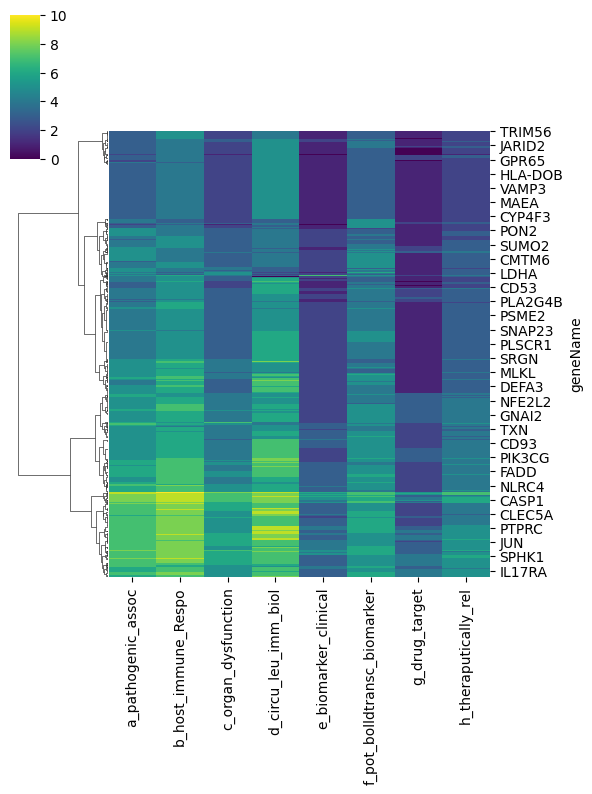

In [324]:
gv = sns.clustermap(dataX,col_cluster=False,method="ward",figsize=(6,8),cmap="viridis")

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_75093/3394965171.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


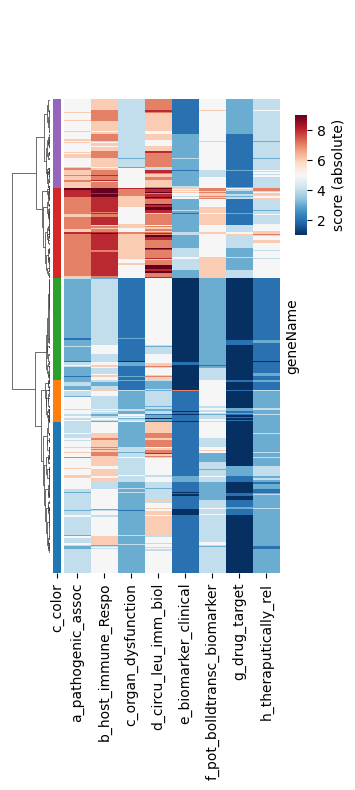

In [335]:
clustNum = get_clusterMembers(gv,g.dendrogram_row.linkage,numCluster=5,schema="tab20",data_scale="absolute")

In [341]:
AggFracPlot.properties(title="Module Agregates")

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.VConcatChart(...)

In [344]:
moduleFracPlot.properties(title="Module IDs")

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.VConcatChart(...)

In [561]:
p1= TitleFracPlot.properties(title="Module Title")
p2 = AggFracPlot.properties(title="Module Agregates")
p3 = moduleFracPlot.properties(title="Module IDs")

bigplot = alt.vconcat(p1,p2,p3)

In [563]:
bigplot.save("../../../../g4API_app/bloodgen3Gensets/Sepsis/Figures/BigPlotallData.html")

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df

In [562]:
bigplot

/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/khant/JaX_work/StreamLitApp/geneLLM/openAIFunc/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df

alt.VConcatChart(...)

### Polar plot for top condidate genes for each cluster

In [461]:
import numpy as np
def do_polarplot(df,title):
    """
    df = Dataframe with top quantile genes
    """
    # Convert the column labels (except for the first column which is gene_name) into angles
    data = df.reset_index()
    labels = data.columns[1:]  # Exclude the gene_name column for the labels
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The radar chart plots a circle, so we need to "complete the loop" and append the start value to the end.
    angles += angles[:1]

    # Plotting
    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))

    # Function to create the plot for each gene
    def add_to_plot(ax, values, label):
        values = np.concatenate((values,[values[0]]))
        ax.plot(angles, values, linewidth=1, linestyle='--', label=label,marker="o")
    #    ax.fill(angles, values, alpha=0.25)

    # Loop through each row and add the plot
    for index, row in data.iterrows():
        add_to_plot(ax, row[1:].values, row[0])

    # Labels for each category
    ax.set_theta_offset(np.pi / 2)  # Start the top
    ax.set_theta_direction(-1)  # Move clockwise

    # Draw one axe per variable and add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    # Draw ytick labels to show scale
    ax.set_rlabel_position(0)
    plt.yticks([2,4,6,8], ["2","4","6","8"], color="grey", size=7)
    plt.suptitle(title, fontsize=16)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 0.75), ncols=1,fontsize=14)

In [388]:
module_agg_DF[module_agg_DF.geneCount>3].sort_values(by="ModuleID")

,ModuleID,c_id,ModuleTitle,AggregateNumber,geneCount,geneFraction,geneList,a_pathogenic_assoc,b_host_immune_Respo,c_organ_dysfunction,d_circu_leu_imm_biol,e_biomarker_clinical,f_pot_bolldtransc_biomarker,g_drug_target,h_theraputically_rel
432,M10.1,4,Interferon,A28,4,0.333333,"IFIT5,IFIT2,PARP14,IFIH1",4.500000,5.750000,3.250000,6.000000,2.000000,4.500000,1.000000,3.000000
25,M10.4,1,Neutrophil activation,A38,6,0.545455,"MPO,LTF,OLFM4,BPI,CTSG,DEFA1",7.000000,8.000000,5.000000,8.333333,3.500000,6.000000,2.500000,4.500000
47,M12.10,1,Inflammation,A35,4,0.400000,"ALOX5,CXCL16,ITGAX,CEBPD",6.750000,7.750000,5.250000,7.750000,3.000000,5.750000,2.500000,4.250000
434,M12.2,4,Monocytes,A26,5,0.333333,"EDG3,PLA2G7,CEBPA,KLF4,MAFB",4.600000,5.800000,3.600000,5.800000,2.000000,4.200000,1.200000,3.200000
55,M12.2,1,Monocytes,A26,5,0.333333,"CYBB,CD163,LY86,CCR2,CD36",6.600000,7.600000,5.600000,7.600000,3.600000,5.600000,3.000000,4.600000
191,M12.2,2,Monocytes,A26,4,0.266667,"CD33,CD86,CSF1R,CARD9",5.250000,6.250000,4.000000,7.000000,2.750000,5.000000,2.250000,4.000000
520,M12.8,5,B cells,A1,5,0.714286,"CD72,CD19,FCER2,HLA-DOB,CD79B",2.800000,4.400000,2.200000,5.400000,1.000000,3.200000,1.000000,2.000000
450,M13.1,4,Inflammation,A35,12,0.324324,"TXN,MLKL,AOAH,CKLF,RXRA,PARP9,FTH1,LST1,CLEC12...",4.750000,5.500000,3.416667,5.416667,2.083333,4.000000,1.083333,3.166667
228,M13.1,2,Inflammation,A35,6,0.162162,"PADI4,PELI1,CD55,STAT5B,TIMP1,AIF1",5.500000,6.333333,4.333333,6.333333,2.666667,4.833333,2.333333,4.166667
623,M13.1,5,Inflammation,A35,5,0.135135,"CYP4F3,SIGLEC10,NOTCH1,SLA,EDG6",3.000000,4.200000,2.200000,5.200000,1.200000,3.000000,0.600000,2.000000


In [462]:
dfx = atL1_evd_annpt_cluster[(atL1_evd_annpt_cluster.ModuleID=="M13.1")&(atL1_evd_annpt_cluster.ClusterName==1)][score_cols]
dfx['totalScore'] = dfx.sum(axis=1)
dfx_filter_qaunt = dfx[dfx.totalScore>=dfx.totalScore.quantile(0.75)]

if dfx_filter_qaunt.shape[0]<3:
    print (dfx_filter_qaunt.shape[0])
    dfx_filter = dfx.sort_values(by="totalScore",ascending=False).head(3)
else:
    dfx_filter = dfx_filter_qaunt

In [463]:
dfx_filter

,a_pathogenic_assoc,b_host_immune_Respo,c_organ_dysfunction,d_circu_leu_imm_biol,e_biomarker_clinical,f_pot_bolldtransc_biomarker,g_drug_target,h_theraputically_rel,totalScore
geneName,,,,,,,,,
CASP1,8.0,8.0,7.0,7.0,4.0,6.0,5.0,6.0,51.0
MYD88,8.0,9.0,6.0,8.0,4.0,7.0,3.0,5.0,50.0
PRKCD,7.0,8.0,6.0,7.0,3.0,5.0,4.0,6.0,46.0
SELL,7.0,8.0,5.0,9.0,4.0,6.0,3.0,5.0,47.0


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_75093/1691137950.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  add_to_plot(ax, row[1:].values, row[0])


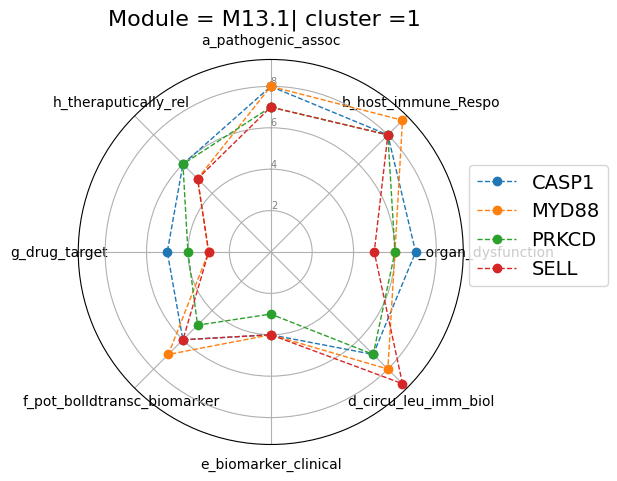

In [464]:
do_polarplot(dfx_filter[score_cols], title = "Module = {}| cluster ={}".format("M13.1","1"))

In [465]:
dfx = atL1_evd_annpt_cluster[(atL1_evd_annpt_cluster.ModuleID=="M13.1")&(atL1_evd_annpt_cluster.ClusterName==2)][score_cols]
dfx['totalScore'] = dfx.sum(axis=1)
dfx_filter_qaunt = dfx[dfx.totalScore>=dfx.totalScore.quantile(0.75)]

if dfx_filter_qaunt.shape[0]<3:
    print (dfx_filter_qaunt.shape[0])
    dfx_filter = dfx.sort_values(by="totalScore",ascending=False).head(3)
else:
    dfx_filter = dfx_filter_qaunt

print (dfx_filter.shape[0], dfx.shape[0])

2
3 6


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_75093/1691137950.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  add_to_plot(ax, row[1:].values, row[0])


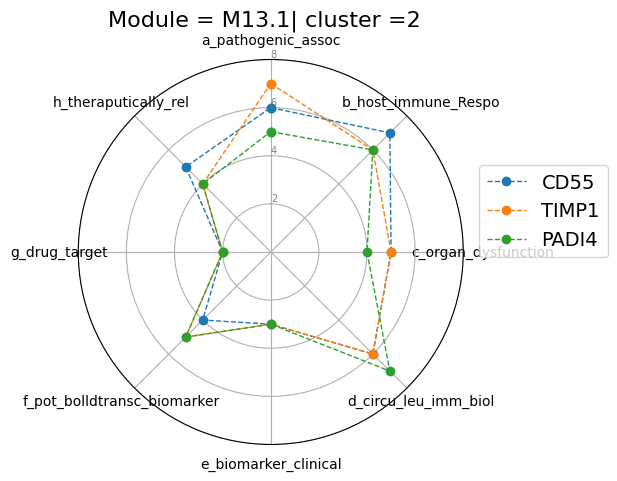

In [466]:
do_polarplot(dfx_filter[score_cols], title = "Module = {}| cluster ={}".format("M13.1","2"))

In [467]:
dfx = atL1_evd_annpt_cluster[(atL1_evd_annpt_cluster.ModuleID=="M13.1")&(atL1_evd_annpt_cluster.ClusterName==4)][score_cols]
dfx['totalScore'] = dfx.sum(axis=1)
dfx_filter_qaunt = dfx[dfx.totalScore>=dfx.totalScore.quantile(0.75)]

if dfx_filter_qaunt.shape[0]<3:
    print (dfx_filter_qaunt.shape[0])
    dfx_filter = dfx.sort_values(by="totalScore",ascending=False).head(3)
else:
    dfx_filter = dfx_filter_qaunt

print (dfx_filter.shape[0], dfx.shape[0])

6 12


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_75093/1691137950.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  add_to_plot(ax, row[1:].values, row[0])


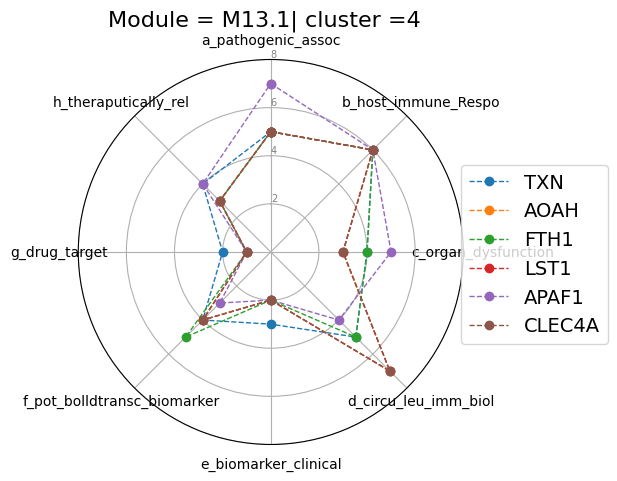

In [468]:
do_polarplot(dfx_filter[score_cols], title = "Module = {}| cluster ={}".format("M13.1","4"))

In [469]:
dfx = atL1_evd_annpt_cluster[(atL1_evd_annpt_cluster.ModuleID=="M13.1")&(atL1_evd_annpt_cluster.ClusterName==5)][score_cols]
dfx['totalScore'] = dfx.sum(axis=1)
dfx_filter_qaunt = dfx[dfx.totalScore>=dfx.totalScore.quantile(0.75)]

if dfx_filter_qaunt.shape[0]<=3:
    print (dfx_filter_qaunt.shape[0])
    dfx_filter = dfx.sort_values(by="totalScore",ascending=False).head(3)
else:
    dfx_filter = dfx_filter_qaunt

print (dfx_filter.shape[0], dfx.shape[0])

3
3 5


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_75093/1691137950.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  add_to_plot(ax, row[1:].values, row[0])


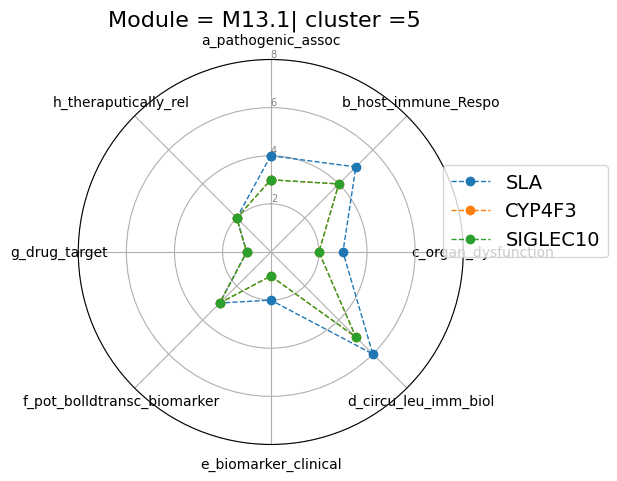

In [470]:
do_polarplot(dfx_filter[score_cols], title = "Module = {}| cluster ={}".format("M13.1","5"))

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_75093/464573432.py:14: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


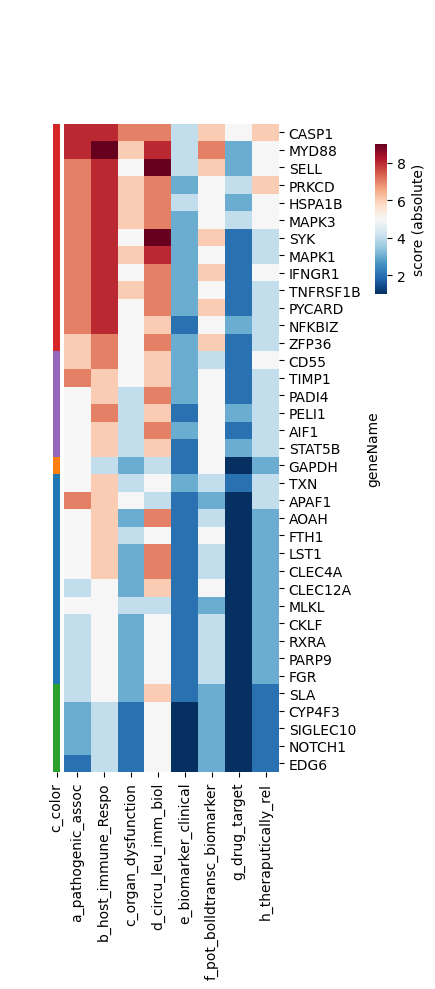

In [460]:
m13_1 = atL1_evd_annpt_cluster[(atL1_evd_annpt_cluster.ModuleID=="M13.1")].sort_values(by=['ClusterName','totalScore'],ascending=[True,False])

sns.set_style()
gt = sns.clustermap(m13_1[score_cols].fillna(0),
                    method="ward",row_cluster=False,col_cluster=False,
                    figsize=(4,10
                    ),cmap="RdBu_r",vmin=1,vmax=9,dendrogram_ratio=0.15,
                    row_colors=m13_1.c_color,
                    cbar_pos=(0.95,0.7,0.03,0.15),
                    cbar_kws={"label":'score (absolute)'})
         
# gt.ax_heatmap.set_yticks(list(m13_1.index))
# gt.ax_heatmap.set_yticks(fontsize=12)
plt.tight_layout()

In [459]:
m13_1

,a_pathogenic_assoc,b_host_immune_Respo,c_organ_dysfunction,d_circu_leu_imm_biol,e_biomarker_clinical,f_pot_bolldtransc_biomarker,g_drug_target,h_theraputically_rel,totalScore,ModuleID,AggregateNumber,ModuleTitle,c_num,c_color,ClusterName
geneName,,,,,,,,,,,,,,,
PYCARD,7.0,8.0,5.0,7.0,3.0,6.0,2.0,4.0,42.0,M13.1,A35,Inflammation,2,#d62728,1
NFKBIZ,7.0,8.0,5.0,6.0,2.0,5.0,3.0,4.0,40.0,M13.1,A35,Inflammation,2,#d62728,1
SELL,7.0,8.0,5.0,9.0,4.0,6.0,3.0,5.0,47.0,M13.1,A35,Inflammation,2,#d62728,1
MAPK3,7.0,8.0,6.0,7.0,3.0,5.0,4.0,5.0,45.0,M13.1,A35,Inflammation,2,#d62728,1
TNFRSF1B,7.0,8.0,6.0,7.0,3.0,5.0,2.0,4.0,42.0,M13.1,A35,Inflammation,2,#d62728,1
CASP1,8.0,8.0,7.0,7.0,4.0,6.0,5.0,6.0,51.0,M13.1,A35,Inflammation,2,#d62728,1
SYK,7.0,8.0,5.0,9.0,3.0,6.0,2.0,4.0,44.0,M13.1,A35,Inflammation,2,#d62728,1
ZFP36,6.0,7.0,5.0,7.0,3.0,6.0,2.0,4.0,40.0,M13.1,A35,Inflammation,2,#d62728,1
HSPA1B,7.0,8.0,6.0,7.0,4.0,5.0,3.0,5.0,45.0,M13.1,A35,Inflammation,2,#d62728,1
